In [ ]:
import cv2 as cv
import numpy as np

# 1. Kép beolvasása
filename = 'sakktabla.jpg'
img = cv.imread(filename)
if img is None:
    print("Hiba: A fájl nem található!")
    exit()

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# 2. Kontraszt javítása (CLAHE) - segít a bábuk melletti sarkoknál
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_enhanced = clahe.apply(gray)

# 3. FAST detektor inicializálása
# threshold: minél kisebb, annál több pontot talál (próbáld 20-50 között)
fast = cv.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)

# 4. Pontok keresése
keypoints = fast.detect(gray_enhanced, None)

# 5. Konvertálás koordinátákká a subpixel finomításhoz
points = np.array([kp.pt for kp in keypoints], dtype=np.float32)

# 6. Subpixel finomítás (ha találtunk pontokat)
if len(points) > 0:
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    # A finomításhoz az eredeti szürke képet használjuk
    refined_points = cv.cornerSubPix(gray, points, (5,5), (-1, -1), criteria)

    # 7. Rajzolás a képre
    for pt in refined_points:
        # A pont koordinátái (x, y)
        x, y = int(pt[0]), int(pt[1])
        # Zöld kör rajzolása: középpont, sugár (5), szín, vastagság (-1 = kitöltve)
        cv.circle(img, (x, y), 2, (0, 255, 0), -1)

# 8. Eredmény mentése
output_name = 'fast_corners_result.png'
cv.imwrite(output_name, img)
print(f"Siker! A bejelölt sarkokat elmentettem: {output_name}")
print(f"Talált sarkok száma: {len(points)}")

Siker! A bejelölt sarkokat elmentettem: fast_corners_result.png
Talált sarkok száma: 2640


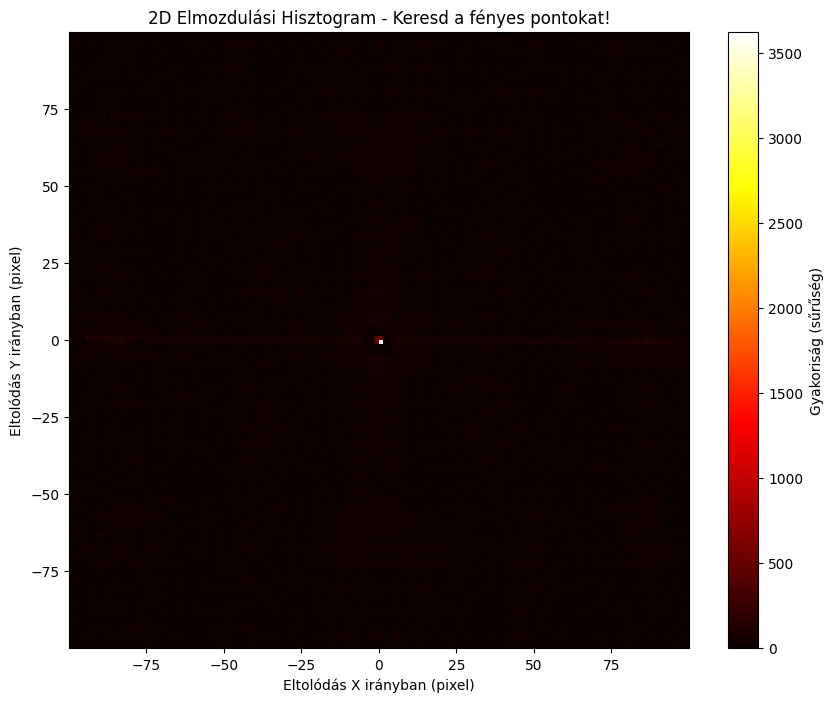

In [10]:
# 9. 2D elmozdulási hisztogram készítése
import matplotlib.pyplot as plt

# Feltételezzük, hogy a 'refined_points' tartalmazza a FAST+Subpixel koordinátákat
# Ha nincs meg a változó, az előző kódodból így nyerheted ki:
# refined_points = np.array([kp.pt for kp in keypoints], dtype=np.float32)

def calculate_displacement_histogram(points, max_dist=100):
    dxs = []
    dys = []
    
    # Minden pontot összehasonlítunk minden másikkal
    for i in range(len(points)):
        # Hatékonyság miatt csak a környező pontokat nézzük (statisztikai minta)
        diffs = points - points[i]
        
        # Csak a releváns távolságon belüli vektorokat tartjuk meg
        mask = (np.abs(diffs[:, 0]) < max_dist) & (np.abs(diffs[:, 1]) < max_dist)
        filtered_diffs = diffs[mask]
        
        dxs.extend(filtered_diffs[:, 0])
        dys.extend(filtered_diffs[:, 1])

    return np.array(dxs), np.array(dys)

# Vektorok kiszámítása
dx, dy = calculate_displacement_histogram(refined_points)

# 2D Hisztogram megjelenítése
plt.figure(figsize=(10, 8))
# bins: a felbontás, minél több, annál élesebb a csúcs
plt.hist2d(dx, dy, bins=150, cmap='hot')
plt.colorbar(label='Gyakoriság (sűrűség)')
plt.title('2D Elmozdulási Hisztogram - Keresd a fényes pontokat!')
plt.xlabel('Eltolódás X irányban (pixel)')
plt.ylabel('Eltolódás Y irányban (pixel)')
plt.show()